## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from lane_detector import LaneDetector
from importlib import reload
%matplotlib qt
%matplotlib inline
%load_ext autoreload
%autoreload 2

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0450560/28549024 bytes (1.61196032/28549024 bytes (4.2%2064384/28549024 bytes (7.2%3031040/28549024 bytes (10.63907584/28549024 bytes (13.74997120/28549024 bytes (17.56111232/28549024 bytes (21.47208960/28549024 bytes (25.38192000/28549024 bytes (28.79306112/28549024 bytes (32.610346496/28549024 bytes (36.2%11436032/28549024 bytes (40.1%12492800/28549024 bytes (43.8%13582336/28549024 bytes (47.6%14630912/28549024 bytes (51.2%15794176/28549024 bytes (55.3%16973824/28549024 bytes (59.5%18120704/28549024 bytes (63.5%19234816/28549024 bytes (67.4%20152320/28549024 bytes (70.6%21315584/28549024 bytes (74.7%22380544/28549024 bytes (78.4%23396352/28549024 bytes (82.0%24444928/28549024 bytes (85.6%25624576/28549024 bytes (89.8%26648576/28549024 bytes (93.3%27754496/28549024 b

In [82]:
# Helper function to plot 2 images side-by side.
def plot_images(image1, image1_title, image2, image2_title):
    plt.figure(figsize=(24,9))
    plt.subplot(1, 2, 1)

    plt.title(image1_title)
    plt.imshow(image1)

    plt.subplot(1, 2, 2)
    plt.title(image2_title)
    plt.imshow(image2)

    plt.show()

### Initialize and calibrate the LaneDetector

In [83]:
lane_detector = LaneDetector()

# Calibrate the lane detector
images = glob.glob('./camera_cal/calibration*.jpg')
lane_detector.calibrate(images)

### Verify the calibration visually by viewing the checkerboard image.

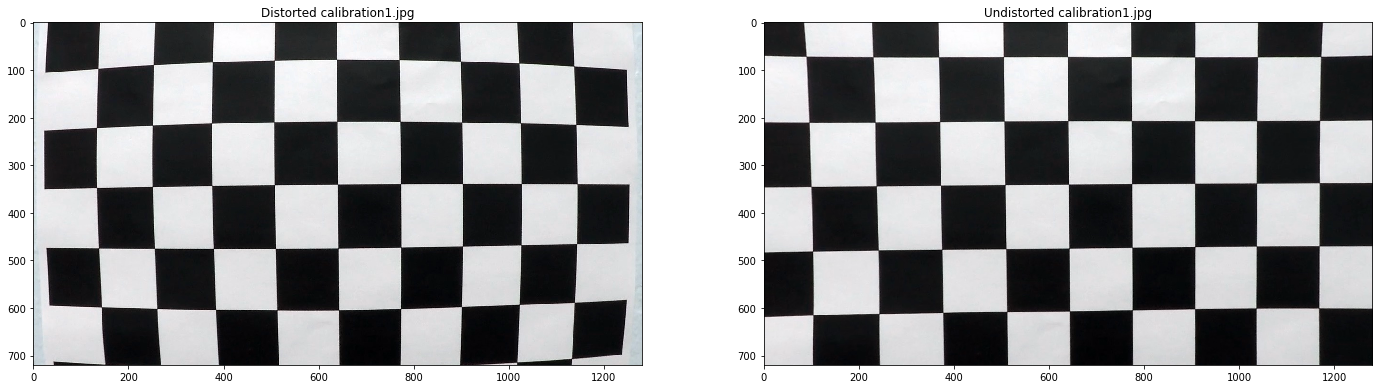

In [84]:
dist_img = cv2.imread('./camera_cal/calibration1.jpg')
undist = lane_detector.undistort(dist_img)
plot_images(dist_img, 'Distorted calibration1.jpg', undist, 'Undistorted calibration1.jpg')

### Verify the calibration visually by viewing the image of the real road.

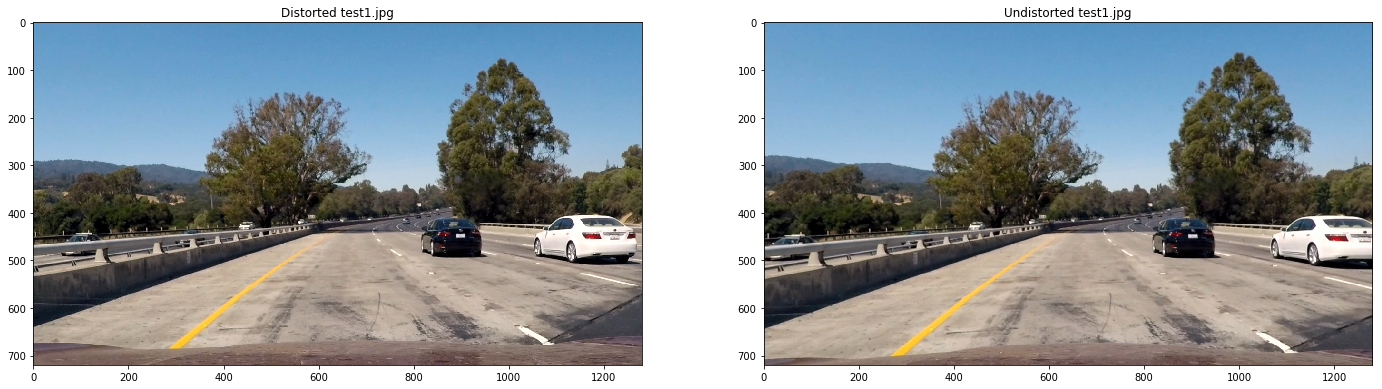

In [85]:
dist_img = cv2.imread('./test_images/test1.jpg')
dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
undist = lane_detector.undistort(dist_img)
plot_images(dist_img, 'Distorted test1.jpg', undist, 'Undistorted test1.jpg')

## Thresholding

In [87]:
# Helper function to read specific frame of a video
def read_video_frame(file_name, frame_number):
    vidcap = cv2.VideoCapture(file_name)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = vidcap.read()
    if not success:
        raise Exception("Failed to read video frame")
    
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

### Thresholding (project video)

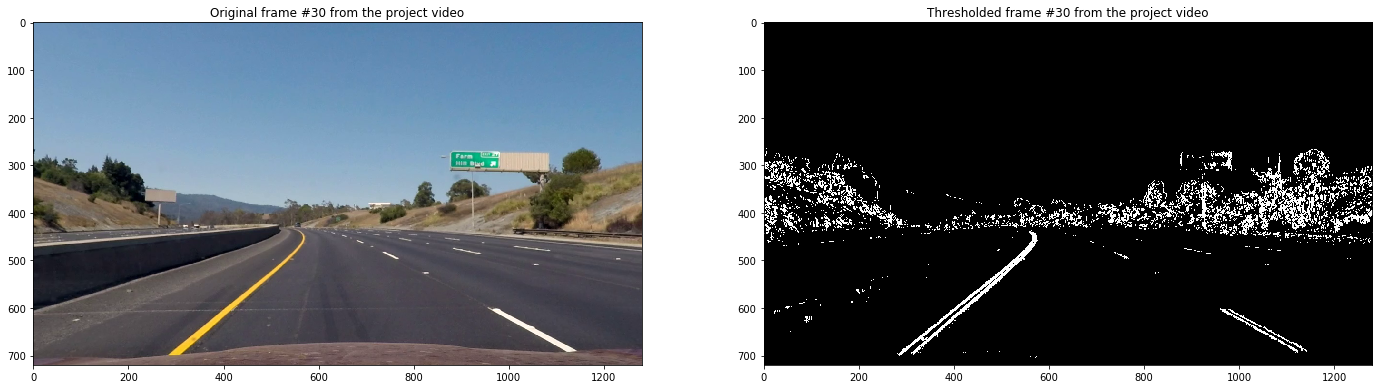

In [110]:
frame = read_video_frame('project_video.mp4', 30)
frame_undistorted = lane_detector.undistort(frame)
frame_binary = lane_detector.binary_image(frame_undistorted)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.title('Original frame #30 from the project video')
plt.imshow(frame_undistorted)

plt.subplot(1, 2, 2)
plt.imshow(frame_binary, cmap='gray')
plt.title('Thresholded frame #30 from the project video')

plt.show()

### Thresholding (challenge video)

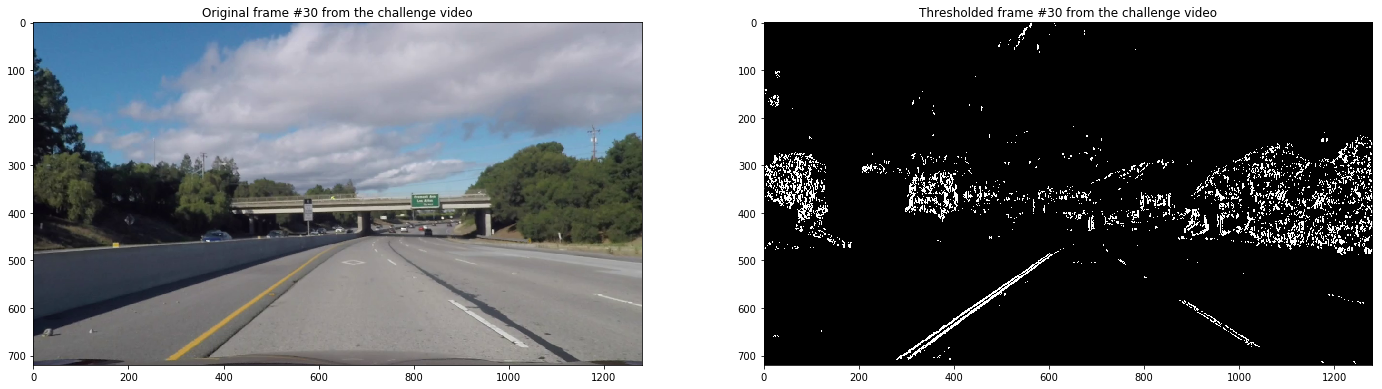

In [109]:
frame = read_video_frame('challenge_video.mp4', 30)
frame_undistorted = lane_detector.undistort(frame)
frame_binary = lane_detector.binary_image(frame_undistorted)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.title('Original frame #30 from the challenge video')
plt.imshow(frame_undistorted)

plt.subplot(1, 2, 2)
plt.imshow(frame_binary, cmap='gray')
plt.title('Thresholded frame #30 from the challenge video')

plt.show()

## Warp

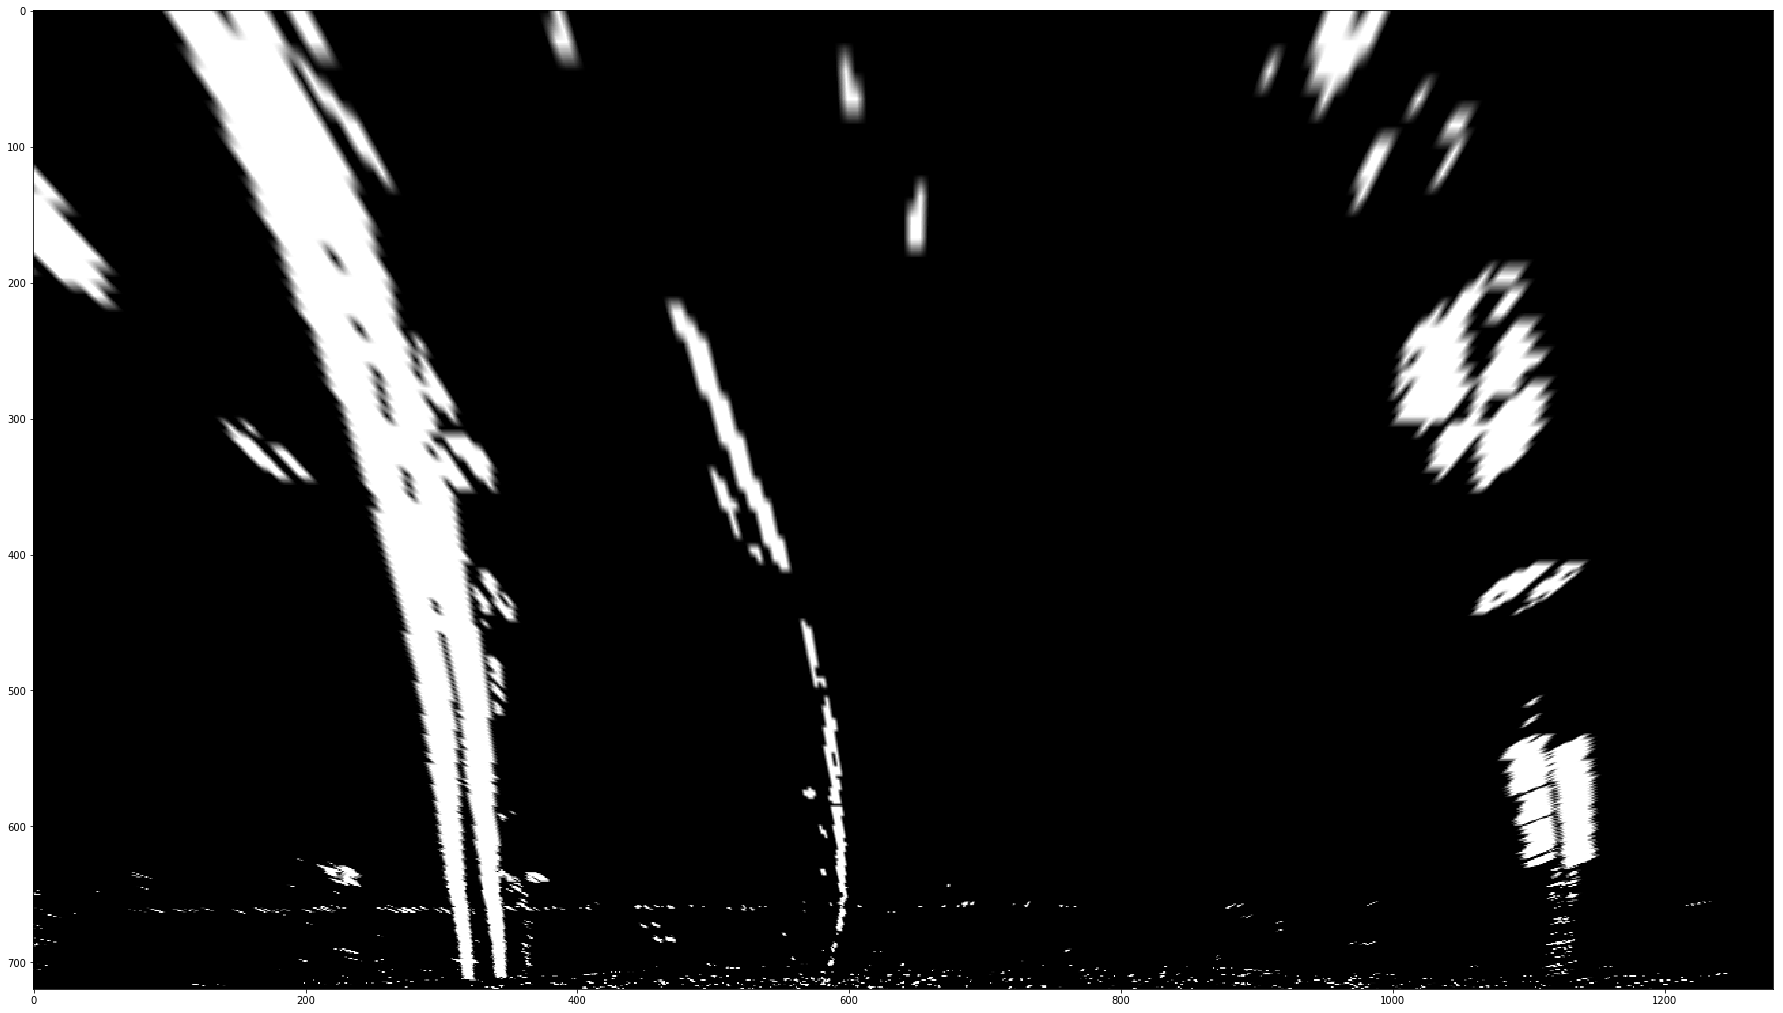

In [108]:
M, Minv = lane_detector.warp_matrices(result)#
warped = lane_detector.warp_perspective(result, M)
plt.figure(figsize = (48,18))
plt.imshow(warped, cmap='gray')

In [186]:
## Histogram

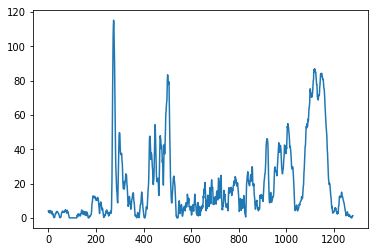

In [33]:
# Create histogram of image binary activations
histogram = lane_detector.hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

In [83]:
## Fit lane pixels

fitting polynomial to:  (720, 1280)


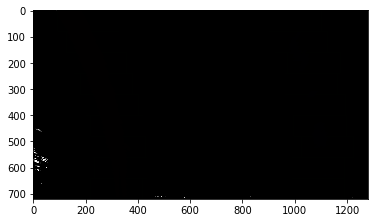

In [51]:
print('fitting polynomial to: ', warped.shape)
lane_detector.reset()
ploty, left_fitx, right_fitx, out_img = lane_detector.fit_lane_lines(warped)
plt.imshow(out_img)

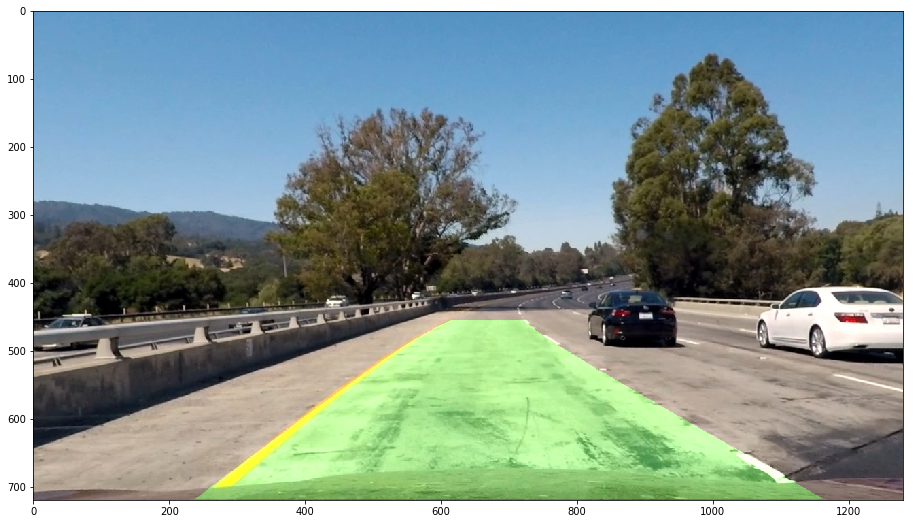

In [38]:
# Create an image to draw the lines on

def unwarp(image, binary_warped, ploty, left_fitx, right_fitx):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    #print(color_warp.shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    #print('img shape: ', image.shape, ' warp shape: ', newwarp.shape)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

result = unwarp(undist, warped, ploty, left_fitx, right_fitx)
plt.figure(figsize = (24,9))
plt.imshow(result)

In [103]:
lane_detector.reset()
def process_image(image):
    image = lane_detector.undistort(image)
    image_original = image
    
    image = lane_detector.binary_image(image)
    
    M, Minv = lane_detector.warp_matrices(image)
    warped = lane_detector.warp_perspective(image, M)
    
    ploty, left_fitx, right_fitx, imagee = lane_detector.fit_lane_lines(warped)
    
    image = unwarp(image_original, warped, ploty, left_fitx, right_fitx)
    
    image = lane_detector.draw_lane_data(image, ploty)
        
    return image


output = 'harder_challenge_video_processed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(5,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_processed.mp4
[MoviePy] Writing video harder_challenge_video_processed.mp4


 99%|█████████▉| 125/126 [00:33<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_processed.mp4 

CPU times: user 38.1 s, sys: 4.27 s, total: 42.3 s
Wall time: 34.5 s
